# Evolutionary Algorithm: Picture generation
*Kivotova Evgenia, March 2019*

*GitHub:[Genvekt](https://github.com/Genvekt/Genetic-algorithm-for-picture-generation)*


## Sections
- [1. **General Description**](#General-Description)
3. [2. **Image processing**](#Image-processing)
    - [2.1 Input parameters](#Input-parameters)
    2. [2.2 Supporting functions](#Supporting-functions:)
    
3. [3. **EA description**](#Evolutionary-algorithm-description)
    - [3.1 Definitions](#Definitions)
    2. [3.2 Chromasomas](#Chromasomas)
    2. [3.3 Fitness Function](#Fitness-Function)
    2. [3.4 Selection](#Selection)
    2. [3.5 Cross Over](#Cross-Over)
    2. [3.6 Mutation](#Mutation)
    2. [3.7 Summary](#Resulting-structure-of-Genetic-Algorithm)
4. [4. **WorkSpace**](#WorkSpace)
    - [4.1 Defining initial image:](#Defining-initial-image:)
    2. [4.2 Defining color combination: Precalculated patettes](#Defining-color-combination:-Use-precalculated-patettes)
        - [4.2.1 Type I: Triad Combination](#Type-I:-Triad-Combination)
        - [4.2.2 Type II: Analogy Combination](#Type-II:-Analogy-Combination)
        - [4.2.3 Type III: Contrast Combination](#Type-III:-Contrast-Combination)
    - [4.3 Defining color combination: Castom patettes](#Defining-color-combination:-Castom-patettes)
    2. [4.4 Running algorithm](#Running-algorithm:)

## General Description

***

This notebook uses Evolutionary algorithm to process input image into one that is desired to be beautiful.

The ideal of beauty is specified by some *color combination*, incluting the desired colors and their percentage ratio.

## Image processing
***
### Input parameters
The used Tools and Libraries are spesified here:

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math, random, time
import ipywidgets as widgets

Global variables which are used through the whole algorithm:

In [3]:
total_pix = 0              #the total number of pixels in the image

color_list = []            #the list of used colors in RGB format
combinations_weights = []  #the list of color ids + its desired percentage ratio in picture
combinations = []          #the list of color ids + its desired number of pixels in image

selection_amount = 10  #the number of chromosomes to be selected for cross over
mutation_barier_rotation = 0.2     #the probability of rotation
mutation_barier_color_change = 0.4 #the probability of one color change by another

### Supporting functions:

In [4]:
#distance between 2 points in 3D
def distance(v1, v2):
    return math.sqrt(pow(v1[0]-v2[0],2)+pow(v1[1]-v2[1],2)+pow(v1[2]-v2[2],2))

In [5]:
#convert image to matrix with ids of used colors
def img_to_colors(img,colors):
    h,w = img.size
    data = np.array(img).tolist()
    codes = []
    for row in data:
        c_row = []
        for pix in row:
            index = 0
            dest = 10000.0
            for i in range(len(colors)):
                dest_temp = distance(colors[i],pix)
                if dest_temp < dest:
                    dest = dest_temp
                    index = i
            c_row.append(index)
        codes.append(c_row)
    return(codes)

In [6]:
def code_to_img(codes,colors):
    arr = []
    for row in codes:
        for i in row:
            arr.append(tuple(color_list[colors.get(i)]))
            
    img2 = Image.new('RGB', tuple([len(codes),len(codes[0])]))
    img2.putdata(arr)
    return img2

In [7]:
#compute list of pixels per color from combinations_weights and total_pix 
def eval_combinations(tot_pix, combi):
    res = []
    for comb  in combi:
        res_comb = []
        for col in comb:
            res_comb.append([col[0],int(tot_pix*col[1])])
        res.append(res_comb)
    return(res)

In [8]:
def custom_palette():
    print("How many colors combination will have?")
    n_cols = int(input())
    for i in range(n_cols):

        palette.append([
            widgets.ColorPicker(
                concise=False,
                description='Color '+str(i+1)+':',
                value='#ffffff',
                disabled=False
            ),
            widgets.IntSlider(
                value=0,
                min=0,
                max=100,
                step=1,
                description='Amount:',
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='d'
            )
        ])

    for i in range(n_cols):
        display(palette[i][0])
        display(palette[i][1])

In [9]:
def palette_to_combination():
    total = 0
    color_list = []
    combinations_weights = [[]]
    for i in range(len(palette)):
        total+=palette[i][1].value
    for i in range(len(palette)):
        h = palette[i][0].value.lstrip('#')
        color_list.append([int(h[i:i+2], 16) for i in (0, 2, 4)])
        combinations_weights[0].append([i,palette[i][1].value/total])
    return(color_list, combinations_weights)
    

In [10]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )


## Evolutionary algorithm description
***
### Definitions
In this algorithm, the text terminology and methods are used:

| Chromosoma         | Population     |Selection      |Cross over|Mutations|
|--------------------|----------------|---------------|----------|-----------|
| Full sized picture |Set of pictures |Selection Wheel|Cut and merge pictures| Rotation and color change|



### Chromasomas

Chromasoma is presented by coded picture with dictionary mapping code to color.

The initial population is created from initial image simply by color shifting:

In [11]:
def create_population(img,colors):
    print("Creating population...")
    data = img_to_colors(img,colors)
    chroms = []
    indexes = [i for i in range(len(colors))]
    for i in range(len(colors)):
        dic = {}
        temp = indexes[1:]
        temp.append(indexes[0])
        indexes = temp
        for i in range(len(colors)):
            dic[i] = indexes[i]
        chroms.append([data,dic])
    print("Creation done.")
    return(chroms)

### Fitness Function
The fitnes function evaluates the difference between curent distribution of colors with desired destribution. Also, it tracks the color despersion, so that picture do not became so that the picture does not become too noisy.

In general, if we define differense as **_D_**, dispersion value as **_N_**, total number of pixels as **_P_** and total number of colors used as **_C_**, the formula for beauty score **_B_** may be shown as:

$\begin{equation} B = \frac{P  C }{1 + D + \frac{1}{2}P N} \end{equation}$

This equation is choosed so that with smal change of D or N the B changes a lot.

In [12]:
def eval_beauty(popularity, dispertion):
    beauty = total_pix*len(popularity)
    b = 100
    for comb in combinations:
        comb_beauty = 0
        for col in comb:
            comb_beauty += abs(popularity[col[0]] - col[1])
        if comb_beauty < beauty:
            beauty = comb_beauty
    return(total_pix*len(popularity)/(1+beauty+(total_pix/2*dispertion)))

In [13]:
def eval_fitness(chroms):
    fitness = []
    for c in chroms:
        popularity = [0 for i in range(len(c[1]))] #popularity of each color
        dispersion = 0.0                           #dispersion of colors
        m = len(c[0])
        n = len(c[0][0])
        for i in range(m):
            for j in range(n):
                disp_local = 0.0
                popularity[c[1].get(c[0][i][j])] += 1
                if(i>0) and c[0][i][j] != c[0][i-1][j]:
                    disp_local += 0.25
                if(i<m-1) and c[0][i][j] != c[0][i+1][j]:
                    disp_local += 0.25
                if(j>0) and c[0][i][j] != c[0][i][j-1]:
                    disp_local += 0.25
                if(j<n-1) and c[0][i][j] != c[0][i][j+1]:
                    disp_local += 0.25
                dispersion += disp_local
        dispertion_total = dispersion/(4*0.5+2*(m-2)*0.75+2*(n-2)*0.75+(m-2)*(n-2))
        fitness.append(eval_beauty(popularity,dispertion_total))
    return(fitness)

### Selection
To perform selection of chromasoms for next population the Weel method is used

In [14]:
def selection(chroms,fitness):
    p = []
    total = sum(fitness)
    for f in fitness:
        p.append(f/total)
    com = []
    com.append(p[0])
    for i in range(1,len(p)):
            com.append(com[i-1]+p[i])
            
    result = []
    for i in range(selection_amount):
        up = 0
        arrow = random.random()
        k = 0
        while(com[k]<arrow):
            k += 1
        result.append(chroms[k])
    return(result)

### Cross Over
In crossover stage, the chromasoms are united to pairs of CH1 and CH2. Then random number A is choosed from range (0,1) and then two new chromasoms are created, first comtaining the A part of CH1 from left and (1-A) part of CH2 from right, second - the A part of CH2 from left and (1-A) part of CH1 from right.

In [15]:
def cross_over(chroms):
    children = []
    for i in range(int(len(chroms)/2)):
        a, b = combine(chroms[i*2], chroms[i*2+1])
        children.append(a)
        children.append(b)
    return(chroms+children)

In [16]:
def combine(ch1, ch2):
    tlt12 = {}
    tlt21 = {}
    child1 = [[],ch1[1]]
    child2 = [[],ch2[1]]
    m = len(ch1[0])
    n = len(ch1[0][0])
    alpha = int(n*random.random())
    
    
    for code1, col1 in ch1[1].items():
        for code2, col2 in ch2[1].items():
            if col1 == col2:
                tlt12[code1] = code2
                tlt21[code2] = code1
                break
                
    for i in range(m):
        r1 = []
        r2 = []
        for j in range(n):
            if j<(alpha):
                r1.append(ch1[0][i][j])
                r2.append(ch2[0][i][j])
            else:
                r1.append(tlt21.get(ch2[0][i][j]))
                r2.append(tlt12.get(ch1[0][i][j]))
               
        child1[0].append(r1)
        child2[0].append(r2)
    return(child1, child2)

### Mutation
Mutation is defined by random rotation (90 clockwise) and random color change.

In [17]:
def mutation(chroms):
    for i in range(len(chroms)):
        #examin rotation
        ror = random.random()
        if ror < mutation_barier_rotation: #mutation happens
            mutated_chrom = [rotate(chroms[i][0]),chroms[i][1]]
            chroms[i] = mutated_chrom
        #examin color change
        ror = random.random()
        if ror < mutation_barier_color_change: #color change happens
            c1 = random.randint(0,len(chroms[i][1])-1)
            c2 = random.randint(0,len(chroms[i][1])-1)
            while(c1 == c2):
                c2 = random.randint(0,len(chroms[i][1])-1)
            mutated_chrom = [change_color(chroms[i][0],c1,c2),chroms[i][1]]
            chroms[i] = mutated_chrom
    return chroms

In [18]:
def rotate(matrix):
    return ([list(row) for row in zip(*matrix[::-1])])

In [19]:
def change_color(matrix,c1,c2):
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] == c1:
                matrix[i][j] = c2
    return matrix

### Resulting structure of Evolutionary Algorithm

In [20]:
def ea(img,colors,populations):
    chromasoms = create_population(img, color_list)
    initial = chromasoms[len(chromasoms)-1]
    f_best = [[],[]]
    for i in log_progress(range(populations)):
        fit = eval_fitness(chromasoms) 
        win = np.argmax(fit)
        f_best[0].append(i)
        f_best[1].append(fit[win])
        chromasoms = mutation(cross_over(selection(chromasoms, fit)))
    
 
    fit = eval_fitness(chromasoms)
    win = np.argmax(fit)
    
    plt.plot(f_best[0], f_best[1])
    return(code_to_img(chromasoms[win][0],chromasoms[win][1]))


In [21]:
def show_chroms(chromes, columns, rows):
    fig=plt.figure(figsize=(10, 30))
    i = 1;
    for c in chromes:
        fig.add_subplot(rows, columns, i)
        plt.imshow(code_to_img(c[0],c[1]))
        plt.axis("off")
        i+=1

## WorkSpace
***
In this section user may set up algorithm parameters and see the results or its work

### Defining initial image:
Image may be any size, but MUST be square-shaped so that all sides are equal (128x128, 512x512, etc.). The larger image, the slower its processing.

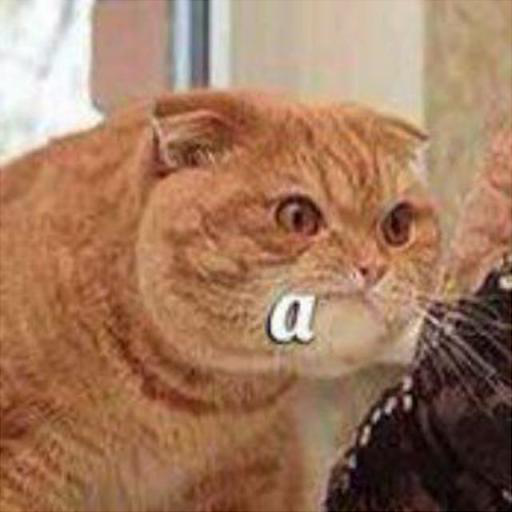

In [22]:
try:  
    img  = Image.open("Test/test_img.jpg")
    w,h = img.size
    total_pix = w*h
except IOError: 
    print("No such image!")
img

### Defining color combination: Use precalculated patettes
#### Type I: Triadic Combination

__[Palette 1:](https://colorscheme.ru/export/screenshot/palette_3831Sw0w0w0w0.png.html)__
<table>
    <tr>
        <td> <img src="files/Palettes/Screenshot_1.png" alt="Snow" style="width:80%"></td>
        <td> <img src="files/Palettes/1.png" alt="Forest" style="width:80%"></td>
    </tr>
</table>



In [23]:
color_list =[[0, 168, 118],[32, 126, 98],[0, 109, 76],[53, 212, 164],[95, 212, 177],[255, 153, 0],
             [191, 134, 48],[166, 99, 0],[255, 178, 64],[255, 199, 115],[237, 0, 47],[178, 45, 71],
             [154, 0, 30],[246, 62, 98],[246, 111, 137],[255, 255, 255],[0, 0, 0],[0, 128, 255],
             [255, 0, 255],[171, 171, 171]]

In [24]:
combinations_weights = [[[0, 0.25],[1, 0.06],[2, 0.06],[3, 0.06],[4, 0.06],[5, 0.13],[6, 0.03],
                         [7, 0.03],[8, 0.03],[9, 0.14],[10, 0.03],[11, 0.03],[12, 0.03],[13, 0.03],
                         [14, 0.03],[15, 0.0],[16, 0.0],[17, 0.0],[18, 0.0],[19, 0.0]]]

__[Palette 2:](https://colorscheme.ru/export/screenshot/palette_2r31Sw0w0w0w0.png.html)__
<table>
    <tr>
        <td> <img src="files/Palettes/Screenshot_2.png" alt="Snow" style="width:80%"></td>
        <td> <img src="files/Palettes/2.png" alt="Forest" style="width:80%"></td>
    </tr>
</table>

In [62]:
color_list =[[142, 235, 0],[124, 176, 44],[92, 153, 0],[172, 245, 61],[192, 245, 110],[255, 24, 0],
             [191, 61, 48],[166, 16, 0],[255, 82, 64],[255, 128, 115],[129, 6, 169],[104, 35, 127],
             [84, 2, 110],[175, 59, 212],[185, 100, 212],[255, 255, 255],[0, 0, 0],[0, 128, 255],
             [255, 255, 0],[171, 171, 171]]

In [63]:
combinations_weights = [[[0, 0.25],[1, 0.06],[2, 0.06],[3, 0.06],[4, 0.06],[5, 0.13],[6, 0.03],
                         [7, 0.03],[8, 0.03],[9, 0.14],[10, 0.03],[11, 0.03],[12, 0.03],[13, 0.03],
                         [14, 0.03],[15, 0.0],[16, 0.0],[17, 0.0],[18, 0.0],[19, 0.0]]]

__[Palette 3:](https://colorscheme.ru/export/screenshot/palette_5h32Fw0w0w0w0.png.html)__
<table>
    <tr>
        <td> <img src="files/Palettes/Screenshot_3.png" alt="Snow" style="width:80%"></td>
        <td> <img src="files/Palettes/3.png" alt="Forest" style="width:80%"></td>
    </tr>
</table>

In [31]:
color_list =[[216, 0, 95],[162, 40, 94],[140, 0, 61],[235, 59, 136],[235, 106, 163],[16, 71, 170],
             [41, 71, 127],[5, 42, 110],[69, 119, 212],[107, 144, 212],[255, 194, 0],[191, 157, 48],
             [166, 126, 0],[255, 209, 64],[255, 221, 115],[255, 255, 255],[0, 0, 0],[0, 255, 0],
             [255, 128, 0],[171, 171, 171]]

In [32]:
combinations_weights = [[[0, 0.25],[1, 0.06],[2, 0.06],[3, 0.06],[4, 0.06],[5, 0.13],[6, 0.03],
                         [7, 0.03],[8, 0.03],[9, 0.14],[10, 0.03],[11, 0.03],[12, 0.03],[13, 0.03],
                         [14, 0.03],[15, 0.0],[16, 0.0],[17, 0.0],[18, 0.0],[19, 0.0]]]

#### Type II: __[ Analogious Combination](https://colorscheme.ru/export/screenshot/palette_0L51Tw0w0w0w0.png.html)__
<table>
    <tr>
        <td> <img src="files/Palettes/Screenshot_4.png" alt="Snow" style="width:80%"></td>
        <td> <img src="files/Palettes/4.png" alt="Forest" style="width:80%"></td>
    </tr>
</table>

In [50]:
color_list = [[255, 151, 0],[191, 133, 48],[166, 98, 0],[255, 177, 64],[255, 198, 115],[255, 195, 0],
              [191, 158, 48],[166, 127, 0],[255, 210, 64],[255, 222, 115],[255, 83, 0],[191, 94, 48],
              [166, 54, 0],[255, 126, 64],[255, 160, 115],[255, 255, 255],[0, 0, 0],[0, 255, 0],
              [0, 128, 255],[255, 0, 128]]

In [51]:
combinations_weights = [[[0, 0.25],[1, 0.06],[2, 0.06],[3, 0.06],[4, 0.06],[5, 0.13],[6, 0.03],
                         [7, 0.03],[8, 0.03],[9, 0.14],[10, 0.03],[11, 0.03],[12, 0.03],[13, 0.03],
                         [14, 0.03],[15, 0.0],[16, 0.0],[17, 0.0],[18, 0.0],[19, 0.0]]]

#### Type III:   __[ Contrast Combination](https://colorscheme.ru/export/screenshot/palette_57227w0w0w0w0.png.html)__

<table>
    <tr>
        <td> <img src="files/Palettes/Screenshot_5.png" alt="Snow" style="width:80%"></td>
        <td> <img src="files/Palettes/5.png" alt="Forest" style="width:80%"></td>
    </tr>
</table>

In [106]:
color_list = [[199, 0, 125],[149, 37, 108],[129, 0, 81],[227, 57, 164],[227, 102, 181],[168, 240, 0],
              [139, 180, 45],[109, 156, 0],[192, 247, 62],[207, 247, 111],[255, 255, 255],[0, 0, 0],
              [0, 255, 255],[0, 0, 255],[255, 128, 0]]

In [108]:
combinations_weights = [[[0, 0.3917525773195876],[1, 0.09278350515463918],[2, 0.09278350515463918],
                         [3, 0.09278350515463918],[4, 0.09278350515463918],[5, 0.13402061855670103],
                         [6, 0.010309278350515464],[7, 0.030927835051546393],
                         [8, 0.030927835051546393],[9, 0.030927835051546393],[10, 0.0],[11, 0.0],
                         [12, 0.0],[13, 0.0],[14, 0.0]]]

### Defining color combination: Castom patettes
Use this to specify castom palette

In [26]:
palette = []
custom_palette()

How many colors combination will have?
1


ColorPicker(value='#ffffff', description='Color 1:')

IntSlider(value=0, continuous_update=False, description='Amount:')

In [ ]:
color_list, combinations_weights = palette_to_combination()

### Running algorithm:
Transform chosen color palette into combination:

In [34]:
combinations = eval_combinations(total_pix, combinations_weights)

Run: The 3 argument defines the number of populations to have:

Creating population...
Creation done.


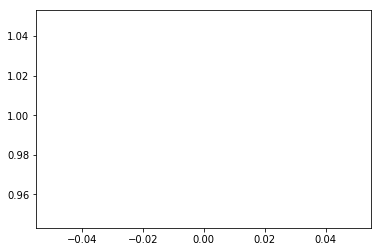

In [27]:
res_img = ea(img, color_list, 100)

Display initial image with the result:

(-0.5, 511.5, 511.5, -0.5)

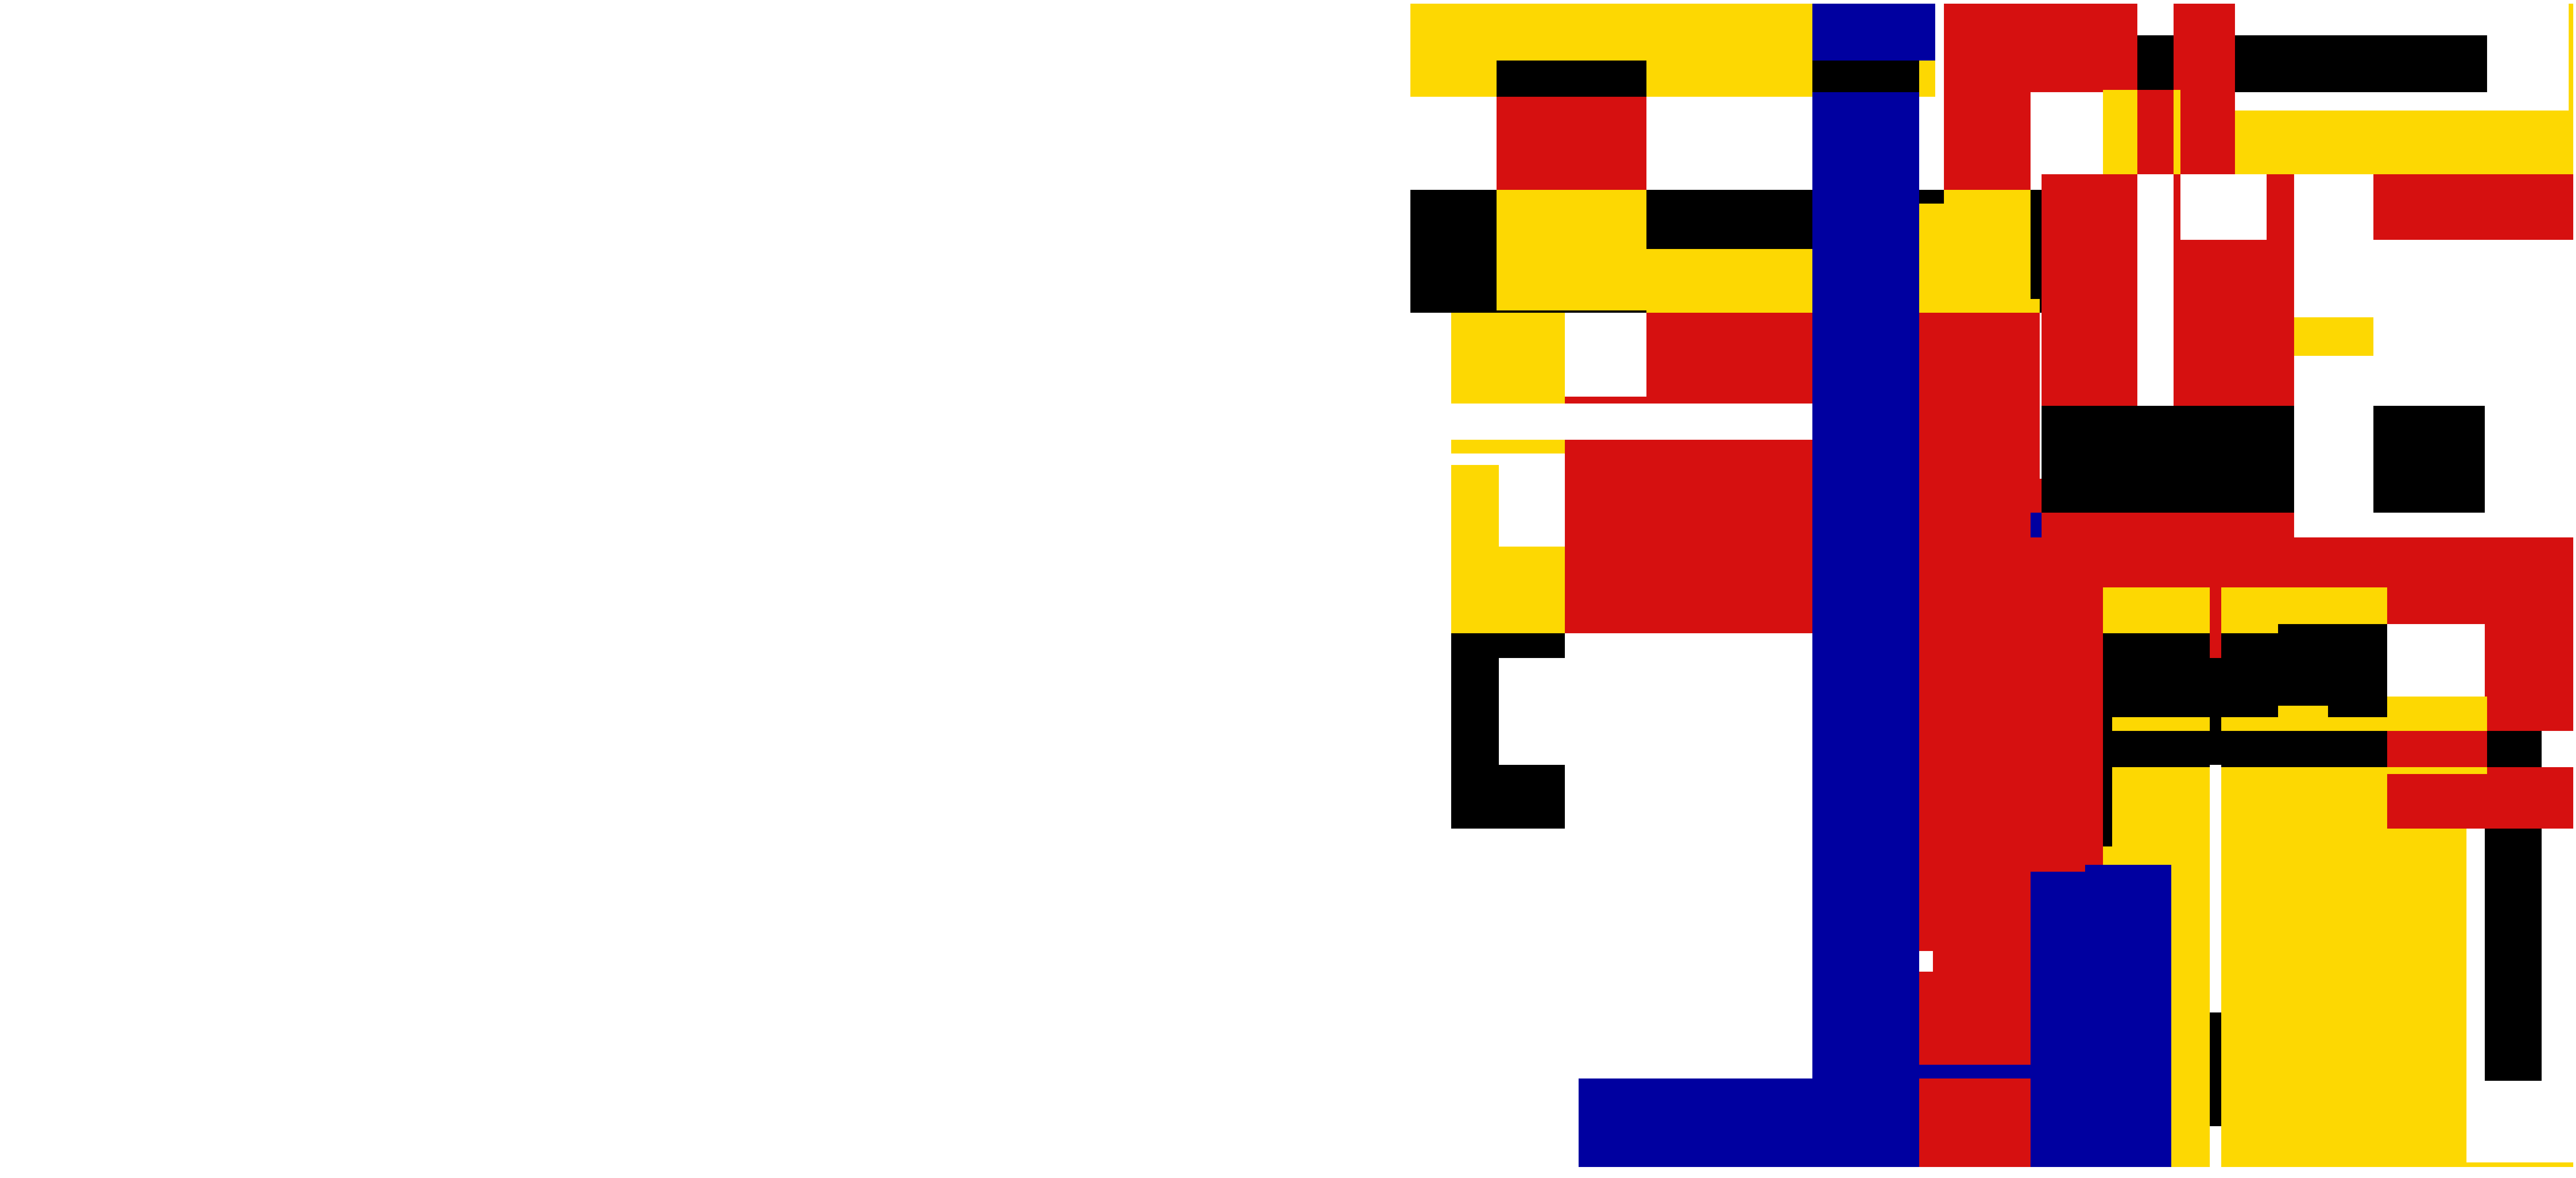

In [105]:
fig = plt.figure(figsize=(100,100))
a=fig.add_subplot(1,2,1)
plt.imshow(img,cmap='Greys_r')
plt.axis('off')
a=fig.add_subplot(1,2,2)
plt.imshow(res_img,cmap='Greys_r')
plt.axis('off')


Save the result:

In [36]:
res_img.save("Results/art3.jpg")